<Body>   
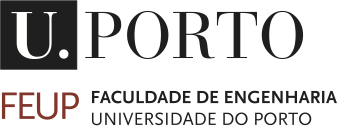   
<h1> <b>Advanced Topics on Machine Learning </b> </h1>
<p><b>Cátia Teixeira</b> (200808037) | <b>Henrique Bastos</b> (202204383) | <b>Ian Karkles</b> (202200596) | <b>Vitor Pereira</b> (202210497)
<p>Master in Data Science and Engineering</p>
</Body>
Faculdade de Engenharia da Universidade do Porto

---

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
from torchsummary import summary
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, average_precision_score
from imblearn.metrics import classification_report_imbalanced
from pycaret.classification import *


# Data preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
#df = pd.read_csv('/content/drive/MyDrive/creditcard.csv')
df = pd.read_csv('/Users/henriqueribeiro/Downloads/creditcard.csv')

#split df into train and test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [3]:
#print the characteristics of the dataframes
print('Train shape: ', df_train.shape)
print('Test shape: ', df_test.shape)

Train shape:  (227845, 31)
Test shape:  (56962, 31)


# Fraud Dataset Creation

In [4]:
class FraudDataset(Dataset):

  def __init__(self, dataframe, fraud = True):
    df = dataframe
    if fraud:
      df = df[df['Class'] == 1]

    x = df.iloc[:, 0:-1].values
    y = df.iloc[:, -1].values
    self.x_data=torch.tensor(x,dtype=torch.float32)
    self.y_data=torch.tensor(y,dtype=torch.float32)

    self.features = x.shape[1]
  def __len__(self):
    return len(self.x_data)

  def __getitem__(self,idx):
    return self.x_data[idx], self.y_data[idx]

creditData = FraudDataset(df_train, fraud= True)
creditDataTest = FraudDataset(df_test, fraud= True)

In [5]:
train_dataloader = DataLoader(creditData, batch_size=32, drop_last=True)
test_dataloader = DataLoader(creditDataTest, batch_size=32, drop_last=True)

## Unconditional Vanilla GAN - Data Augmentation

### Architecture

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(latent_dim, 1024),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(16, nr_features),
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [7]:
class Discriminator(nn.Module):
    def __init__(self, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(nr_features, 256),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(16, 1),

        )
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return torch.sigmoid(x)

In [8]:
class GAN:
    def __init__(self, train_df, latent_size=128):
        self.lr = 0.00005
        self.batch_size = 16
        self.n_critic = 1
        self.clip_value = 0.0001
        self.cur_batch_size = 64
        self.latent_dim = 128
        self.criterion = nn.BCELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.dataset = FraudDataset(train_df, fraud= True)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)

        self.G = Generator(latent_dim=latent_size, nr_features=self.dataset.features).to(self.device)
        self.D = Discriminator(nr_features=self.dataset.features).to(self.device)
        self.latent_size = latent_size

        self.g_optimizer = torch.optim.Adam(self.G.parameters(), self.lr)
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), self.lr)





    def train_generator(self,real_data):
        # Clear generator gradients
        self.g_optimizer.zero_grad()

        fake_targets = torch.ones(real_data.size(0)).to(self.device)
        fake_targets = fake_targets - 0.1

        # Random noise from a uniform distribution
        latent_space_samples = torch.randn(real_data.size(0), self.latent_dim).to(self.device)
        generated_data = self.G(latent_space_samples)  # Fake data generated by the generator
        fake_preds = self.D(generated_data).reshape(-1)

        g_loss = self.criterion(fake_preds, fake_targets)
        g_loss.backward()
        self.g_optimizer.step()

        return g_loss, generated_data

    def train_discriminator(self, real_data, real_labels):
        self.d_optimizer.zero_grad()
        real_labels = torch.ones(real_data.size(0)).to(self.device) * 0.9

        real_preds = self.D(real_data).reshape(-1)
        d_loss_real = self.criterion(real_preds, real_labels)

        fake_labels = torch.zeros(self.cur_batch_size).to(self.device) * 0.1

        # random noise from uniform distribution
        latent_space_samples = torch.randn(self.cur_batch_size, self.latent_dim).to(self.device)


        generated_data = self.G(latent_space_samples).detach()
        fake_preds = self.D(generated_data).reshape(-1)
        d_loss_fake = self.criterion(fake_preds, fake_labels)


        loss = d_loss_real + d_loss_fake

        # Compute gradients
        loss.backward()
        # Adjust the parameters using backprop
        self.d_optimizer.step()


        return loss

    def train(self,real_data, epochs=1000):
        losses_gen = []
        losses_dis = []
        for epoch in range(0,epochs):
            for i, (real_data, real_labels)  in enumerate(self.dataloader):
                real_data, real_labels = real_data.to(self.device), real_labels.to(self.device)
                # Train discriminator
                d_error = self.train_discriminator(real_data, real_labels)
                # Train generator every n_critic iterations
                if i % self.n_critic == 0:
                    g_error, _ = self.train_generator(real_data)
                losses_gen.append(g_error)
                losses_dis.append(d_error)

            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f} \n'
                .format(epoch+1, epochs, i+1, len(self.dataloader), d_error.item(), g_error.item()))

        return losses_gen, losses_dis



    def sample(self, count):
        with torch.no_grad():
            z = torch.Tensor(np.random.normal(0, 1, (count, self.latent_size))).to(self.device)
            gen = self.G(z)
            return gen.cpu().numpy()

### Training the model

In [9]:
gan = GAN(df_train)

In [10]:
losses_gen, losses_dis = gan.train(df_train, epochs=1000)

Epoch [1/1000], Step [25/25], d_loss: 7.4335, g_loss: 0.6058 

Epoch [2/1000], Step [25/25], d_loss: 9.9778, g_loss: 0.6057 

Epoch [3/1000], Step [25/25], d_loss: 9.8987, g_loss: 0.6081 

Epoch [4/1000], Step [25/25], d_loss: 11.5117, g_loss: 0.6081 

Epoch [5/1000], Step [25/25], d_loss: 9.4906, g_loss: 0.6121 

Epoch [6/1000], Step [25/25], d_loss: 8.2178, g_loss: 0.6135 

Epoch [7/1000], Step [25/25], d_loss: 10.8051, g_loss: 0.6108 

Epoch [8/1000], Step [25/25], d_loss: 9.9007, g_loss: 0.6151 

Epoch [9/1000], Step [25/25], d_loss: 8.8818, g_loss: 0.6140 

Epoch [10/1000], Step [25/25], d_loss: 9.8975, g_loss: 0.6171 

Epoch [11/1000], Step [25/25], d_loss: 14.2328, g_loss: 0.6199 

Epoch [12/1000], Step [25/25], d_loss: 8.2788, g_loss: 0.6214 

Epoch [13/1000], Step [25/25], d_loss: 10.7938, g_loss: 0.6198 

Epoch [14/1000], Step [25/25], d_loss: 10.7912, g_loss: 0.6216 

Epoch [15/1000], Step [25/25], d_loss: 8.9236, g_loss: 0.6243 

Epoch [16/1000], Step [25/25], d_loss: 9.939

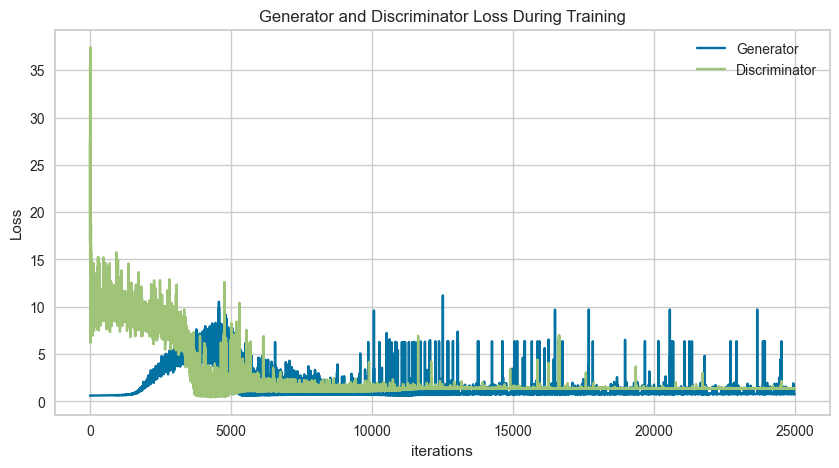

In [11]:
def plot_losses(losses_gen, losses_dis):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")

    #convert losses into numpy
    losses_gen = [i.cpu().detach().numpy() for i in losses_gen]
    losses_dis = [i.cpu().detach().numpy() for i in losses_dis]
    plt.plot(losses_gen,label="Generator")
    plt.plot(losses_dis,label="Discriminator")
    plt.xlabel("iterations") #Epochs * Steps
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_losses(losses_gen, losses_dis)

### Join augmented data + real data

In [12]:
#define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sample_number = df_train[df_train['Class'] == 0].shape[0]
gan_samples = gan.sample(sample_number)
samples_test = np.append(gan_samples, np.ones((sample_number, 1)), axis=1)
gan_df = pd.DataFrame(samples_test, columns=df_train.columns)
#concat wgan_df with df_train
df_concat = pd.concat([df_train, gan_df], ignore_index=True)

In [14]:
df_concat['Class'].value_counts()

1.0    227845
0.0    227451
Name: Class, dtype: int64

# Model evaluation

### Deep Neural Network

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, average_precision_score
from imblearn.metrics import classification_report_imbalanced


def common_metrics(y_true, y_pred, y_prob):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true')
    RocCurveDisplay.from_predictions(y_true, y_prob)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    #
    fig, ax = plt.subplots()
    PrecisionRecallDisplay.from_predictions(y_true, y_prob, ax=ax)
    # P / (P + N)
    ap_frauds = (len(y_true[y_true == 1]) / len(y_true))
    plt.axhline(y=ap_frauds, color='r', linestyle='-')
    plt.show()
    #
    print(classification_report_imbalanced(y_true, y_pred))
    print("AUPRC:", auc(recall, precision))
    print("AP:", average_precision_score(y_true, y_prob))

In [ ]:
class Model(nn.Module):
    def __init__(self, nr_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(nr_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return torch.flatten(self.model(x))

In [ ]:
class FraudModel:
    def __init__(self, train_df):
        self.lr = 0.001
        self.batch_size = 64
        self.dataset = FraudDataset(train_df, fraud = False)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)
        self.model = Model(nr_features=self.dataset.features).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = nn.BCELoss()

    def train(self, epochs=100):
        for epoch in range(epochs):
            epoch_loss = 0
            for _, (x, y) in enumerate(tqdm(self.dataloader)):
                x,y = x.to(device), y.to(device)
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() / len(x)
            print("[Epoch %d/%d] loss: %f" % (epoch+1, epochs, np.mean(epoch_loss)))

    def predict(self, x):
        with torch.no_grad():
            pred = self.model(x)
            return pred.cpu().numpy()

    def evaluate(self, test_df, confidence=0.50):
            input = torch.Tensor(test_df.drop(['Class'], axis=1).values).to(device)
            y_true = torch.Tensor(test_df['Class'].values).to(device)
            #preds = self.predict(input)
            preds = np.array([])
            dataloader_test = DataLoader(TensorDataset(input, y_true), batch_size=64, shuffle=False)

            for (inp, _) in dataloader_test:
                pred = self.predict(inp)
                preds = np.concatenate((preds, pred), axis=None)
            labels = np.zeros_like(preds)
            labels[preds >= confidence] = 1
            common_metrics(y_true.cpu().numpy(), labels,preds)

In [ ]:
fw_model = FraudModel(df_concat)
fw_model.train(epochs=300)
fw_model.evaluate(df_test, confidence=0.90)

In [ ]:
path = "vgan_model.pt"
torch.save(fw_model.model.state_dict(), path)

### LSTM-Based Detection

In [ ]:
#split df_concat into train and test
ltsm_train, ltsm_test = train_test_split(df_concat, test_size=0.2, random_state=42)

In [ ]:
def create_time_dataset(in_df, seq_size=10):
    X, y = [], []
    for i in range(len(in_df) - seq_size):
        slice = in_df[i:i+seq_size]
        X.append(slice.drop(['Class', 'Time'], axis=1).values)
        y.append(slice['Class'].values[-1])

    X = np.array(X)
    y = np.array(y)

    return torch.Tensor(X).to(device), torch.Tensor(y).to(device)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_size = 256
        self.lstm = nn.LSTM(input_size,
                            hidden_size=self.hidden_size,
                            num_layers=5,
                            bidirectional=True,
                            batch_first=True)
        self.linear = nn.Sequential(
            nn.Linear(self.hidden_size * 2, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x, hx = self.lstm(x)
        out = torch.cat((hx[0][-2, :, :], hx[0][-1, :, :]), dim=1)
        return torch.flatten(self.linear(out))

In [ ]:
class LSTMFraudModel:
    def __init__(self, train_df):
        self.lr = 0.0001
        self.batch_size = 128
        X_train, y_train = create_time_dataset(train_df)
        self.dataset = TensorDataset(X_train, y_train)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)
        self.model = LSTMModel(input_size=X_train.shape[2]).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = nn.BCELoss()

    def train(self, epochs=100):
        for epoch in range(epochs):
            epoch_loss = 0
            for _, (x, y) in enumerate(tqdm(self.dataloader)):
                x,y = x.to(device), y.to(device)
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() / len(x)
            print("[Epoch %d/%d] loss: %f" % (epoch+1, epochs, np.mean(epoch_loss)))

    def predict(self, x):
        with torch.no_grad():
            pred = self.model(x)
            return pred.cpu().numpy()

    def evaluate(self, test_df, confidence=0.50):
        input, y_true = create_time_dataset(test_df)
        dataloader = DataLoader(TensorDataset(input, y_true), self.batch_size, shuffle=False)
        preds = np.array([])
        for (inp, _) in dataloader:
            pred = self.predict(inp)
            preds = np.concatenate((preds, pred), axis=None)
        labels = np.zeros_like(preds)
        labels[preds >= confidence] = 1.0
        common_metrics(y_true.cpu().numpy(), labels, preds)

In [ ]:
lstm = LSTMFraudModel(ltsm_train)

In [ ]:
lstm.train(epochs=300)

In [ ]:
lstm.evaluate(df_test,confidence=0.9)

In [ ]:
path = "lstm_model.pth"
torch.save(lstm.model.state_dict(), path)


### Common Regression Models

In [16]:
def common_regression_models(train_df, test_df):
    r = setup(data=train_df, target='Class', session_id=42, train_size=0.80)
    r.add_metric('apc', 'APC', average_precision_score, target='pred_proba')
    best = r.compare_models(sort='AUC')

    pred_df = predict_model(best, data=test_df.copy().drop('Class', axis=1), raw_score=True)
    l = np.argmax(pred_df[['prediction_score_0', 'prediction_score_1']].values, axis=1)
    p = pred_df[['prediction_score_0', 'prediction_score_1']].values.squeeze()
    p_bin = p[:, 1]
    p_bin[l == 0] = 1.0 - p[l == 0][:, 0]
    common_metrics(test_df['Class'].values, l, p_bin)

    return best

In [17]:
#split df_concat into train and test
vgan_train_df, vgan_test_df = train_test_split(df_concat, test_size=0.2, random_state=42)

In [19]:
best_vgan = common_regression_models(vgan_train_df, df_test)


,Description,Value
0,Session id,42
1,Target,Class
2,Target type,Binary
3,Original data shape,"(364236, 31)"
4,Transformed data shape,"(364236, 31)"
5,Transformed train set shape,"(291388, 31)"
6,Transformed test set shape,"(72848, 31)"
7,Numeric features,30
8,Preprocess,True
9,Imputation type,simple


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:40:36
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC,TT (Sec)
lr,Logistic Regression,0.9987,0.9999,0.9977,0.9996,0.9987,0.9973,0.9973,0.9999,14.4810
rf,Random Forest Classifier,0.9998,0.9999,0.9996,0.9999,0.9998,0.9995,0.9995,0.9999,40.4210
ada,Ada Boost Classifier,0.9995,0.9999,0.9994,0.9997,0.9995,0.9991,0.9991,1.0000,31.3360
dt,Decision Tree Classifier,0.9995,0.9995,0.9995,0.9996,0.9995,0.9991,0.9991,0.9993,6.1090
qda,Quadratic Discriminant Analysis,0.9984,0.9993,0.9969,0.9999,0.9984,0.9968,0.9968,0.9992,0.6850
knn,K Neighbors Classifier,0.9978,0.9990,0.9968,0.9987,0.9978,0.9956,0.9956,0.9988,37.7820
nb,Naive Bayes,0.9975,0.9974,0.9971,0.9978,0.9975,0.9950,0.9950,0.9975,0.4410
svm,SVM - Linear Kernel,0.9986,0.0000,0.9981,0.9990,0.9986,0.9971,0.9971,0.0000,2.2090
ridge,Ridge Classifier,0.9978,0.0000,0.9974,0.9981,0.9978,0.9955,0.9955,0.0000,0.4380


Processing:   0%|          | 0/61 [00:00<?, ?it/s]